Functions and Imports

In [1]:
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["font.family"] = "Times New Roman"
from scipy.interpolate import interp1d
import pandas as pd
from scipy.special import jv
from scipy.linalg import solve_sylvester
from scipy.ndimage import binary_fill_holes
import time
from ipywidgets import interact
from ipywidgets import IntSlider


def get_square_H(s,skin_depth,resolution):
    k = (1-1j)/skin_depth
    dx = s/(resolution+1) #stepsize: x direction
    beta_x = 1/dx**2 #avoid repeated operations
    alpha_x = -2*beta_x+k**2/2
    Xmat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize data matrix
    # Ymat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize B matrix
    # corners
    Xmat[0][0] = alpha_x
    Xmat[resolution-1][resolution-1] = alpha_x

    #interior
    for i in range(1,resolution-1):
        Xmat[i][i]= alpha_x #alpha_x

        Xmat[i][i+1]= beta_x #beta_x
        Xmat[i][i-1]= beta_x #beta_x
        #this set the points to the right and left of the diagonal

    #remaining two exterior points
    Xmat[0][1] = beta_x
    Xmat[resolution-1][resolution-2] = beta_x

    C = np.zeros([resolution,resolution],dtype=np.complex_) #boundary conditions (The 
    #component of H parallel to the surface of the conductor is continuous 
    #provided there are no free surface currents.) 

    H_beta_x = -beta_x

    C[0][0] = 2*H_beta_x
    C[resolution-1][0] = 2*H_beta_x
    C[0][resolution-1] = 2*H_beta_x
    C[resolution-1][resolution-1] = 2*H_beta_x

    for i in range(1,resolution-1):
        C[0][i] = H_beta_x
        C[resolution-1][i] = H_beta_x
        C[i][0] = H_beta_x
        C[i][resolution-1] = H_beta_x
        
    X = solve_sylvester(Xmat,Xmat,C)
    
    for i in range(resolution):
        for j in range(resolution):
            if X[i][j].real > 1:
                print("Error at position ",i,", ",j) #It is unphysical for the 
                #field to be larger in magnitude within the conductor than outside of it 
                #(provided that it is not magnetic).            
    NewX= np.zeros([resolution+2,resolution+2],dtype=np.complex_) 
    for i in range(resolution+2): #This for loop defines the field at the surface 
        #of the conductor (It must be H0).
        
        for j in range(resolution+2):
            if ((i ==0) or (i==(resolution+1)) or (j ==0) or (j==(resolution+1))):
                NewX[i][j] =1 
            else:
                NewX[i][j]=X[i-1][j-1]
    return NewX

def get_cylind_H(d,skin_depth,resolution):
    k = (1-1j)/skin_depth
    cylindH = np.ones([resolution+2,resolution+2],dtype=np.complex_)
    demon = 1/jv(0,d/2*k)
    for i in range(1,resolution+1):
        for j in range(1,resolution+1):
            if ((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)*4<=resolution**2:
                cylindH[i][j] = jv(0,np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)*d/(resolution)*k)*demon
    return cylindH

def get_shape_H(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    dx = s/(resolution +1)  # grid spacing

    # Define the initial condition
    # z = np.ones((resolution, resolution), dtype=np.complex128)  # initial solution matrix
    # shape_inds = np.array([])
    # for i in range(1, resolution - 1):  # loop over the interior points in x
    #     for j in range(1, resolution - 1):  # loop over the interior points in y
    #         if mask[i, j] == 1:
    #             r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*s
    #             z[i,j] = jv(0,r*k)/jv(0,s/2*k)
    #             # shape_inds = np.append(shape_inds,(i,j))

    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # for n in range(iterations):
    #     old_z = z.copy()
    #     for i in range(1, resolution - 1):  # loop over the interior points in x
    #         for j in range(1, resolution - 1):  # loop over the interior points in y
    #             if mask[i, j] == 1:  # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (old_z[i+1, j] + old_z[i-1, j] + old_z[i, j+1] + old_z[i, j-1]) * inv_denom

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] += ((z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom - z[i, j])

    # Time to iterate_new ...slower??
    # inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # inx = np.transpose(np.where(mask == 0))
    # print(inx)
    # for n in range(iterations):
    #     for i,j in inx: # loop over the interior points in   
    #                 # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
    return z

def get_shape_H_Show_Phase(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    resolution = len(mask)
    dx = s/(resolution + 1)  # grid spacing
    phases = np.zeros(iterations)

    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
        phases[n] = np.angle(double_Integral(z,s)/s**2-1)
    i1 = np.logical_not(phases<0)
    phases[i1]-= 2*np.pi

    fig = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.arange(iterations),phases)
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('Phase (rad)')
    ax.set_title('Phase behavior')
    plt.show()
    return z

def get_rect_H(l,w,skin_depth,resolution,iters):
    big = max(l,w)
    ratio = min(l,w)/big
    mask = np.zeros([resolution,resolution],dtype=np.float64)
    for i in range(resolution):
        if abs(i/(resolution-1)-.5)< ratio/2: #so the difference from the center point (.5) is ratio/2 or less for each side
            row = [1]*resolution
            row[0] = 0
            row[-1] = 0
            mask[i] = np.array([row])
    return get_shape_H(mask,big,skin_depth,iters)
    # fig = plt.figure(constrained_layout = True)
    # ax = fig.add_subplot(1, 1, 1)
    # ax.imshow(np.absolute(mask))
    # ax.set_xticks(np.arange(0, resolution, step=10))
    # ax.set_yticks(np.arange(0, resolution, step=10))
    # return ''
    
def get_skin_depth(rho,frequency=671111):
    return (rho/(4e-7*np.pi * np.pi *frequency))**.5

def get_shape_H(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    dx = s/(resolution +1)  # grid spacing
    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] += ((z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom - z[i, j])
    return z

def better_guess(mask,s,skin_depth):
    a = np.sqrt(get_area(mask,s)/np.pi) #this is the radius of the circle with the same area of the mask
    rs = get_nearest_edge(mask,s)
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    good_guess = np.ones((resolution, resolution), dtype=np.complex128)
    i = np.logical_not(mask == 0)
    good_guess[i] = jv(0,(a-rs[i])*k)/jv(0,a*k)
    return good_guess

def get_area(mask,s):
    count = 0
    l = len(mask)
    for i in range(l):
        for j in range(l):
            if mask[i][j]:
                count += 1
    return (s**2)*count/((l-2)**2) #this gives area in whatever units are for s**2

def get_nearest_edge(mask,s):
    radii = np.zeros([len(mask),len(mask[0])],dtype=np.float64)
    for i in range(1, len(mask) - 1):  # loop over the interior points in x
        for j in range(1, len(mask[0]) - 1):  # loop over the interior points in y
            reach = 1
            if mask[i, j]:
                r = np.Infinity# r is defined to be the distance between centers of pixels in units of a single pixel length
                while reach < r:
                    if (not(mask[i+reach,j]) or not(mask[i-reach,j]) or not(mask[i,j+reach]) or not(mask[i,j+reach])) and r>reach:#check edge centers if odd
                            r = reach
                            break #if this ever happens, it is always the shortest path because every next point is farther away
                    for edge in range(1,reach): #then check two sqaures on either edge of edge center (eight total places to check for each distance)
                        if (not(mask[i+reach,j+edge]) or not(mask[i+reach,j-edge]) or 
                            not(mask[i-reach,j+edge]) or not(mask[i-reach,j-edge]) or 
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach]) or
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach])) and r**2>reach**2+edge**2:#check edge centers if odd
                            r = np.sqrt(reach**2+edge**2)
                            break # this breaks of because each next edge is farther
                    if (not(mask[i+reach,j+reach]) or not(mask[i-reach,j+reach]) or not(mask[i+reach,j-reach]) or not(mask[i-reach,j-reach])) and r>reach*2**.5:#check edge centers if odd
                            r = reach*2**.5 #check corners
                    reach += 1 #move out a layer
                radii[i,j] = r*s/len(mask)
    return radii

def adjustsize(data, start,end,resolution,outside_val=0):
    if end < start:
        return data
    n = int(end/start*resolution) #new matrix size
    starting_ind = int(resolution*(end/start-1)/2)
    output = np.zeros([n,n],dtype=np.complex_)+outside_val
    for i in range(resolution+2):# assuming the matrix has an outside row of 1s, so its size is resolution +2
        for j in range(resolution+2):
            output[starting_ind + i - 1][starting_ind + j - 1] = data[i][j]
    return output

def double_Integral(data, d):
    n = len(data)#assumes square 2d array that has physical length of d by d meters
    dA = ((d-0)/(n-1)) * ((d-0)/(n-1))

    data_Internal = data[1:-1, 1:-1]

    # sides: up, down, left, right
    (data_u, data_d, data_l, data_r) = (data[0, 1:-1], data[-1, 1:-1], data[1:-1, 0], data[1:-1, -1])

    # corners
    (data_ul, data_ur, data_dl, data_dr) = (data[0, 0], data[0, -1], data[-1, 0], data[-1, -1])

    return dA * (np.sum(data_Internal)\
                + 0.5 * (np.sum(data_u) + np.sum(data_d) + np.sum(data_l) + np.sum(data_r))\
                + 0.25 * (data_ul + data_ur + data_dl + data_dr))

Geometery Simulations

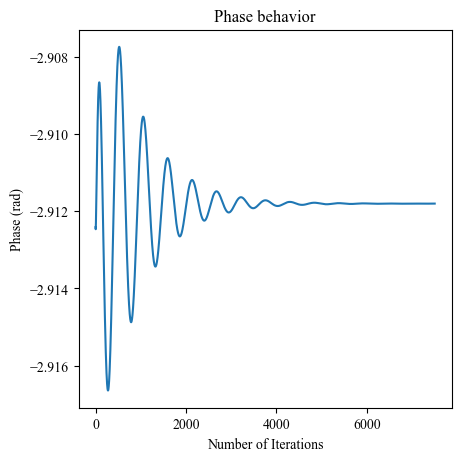

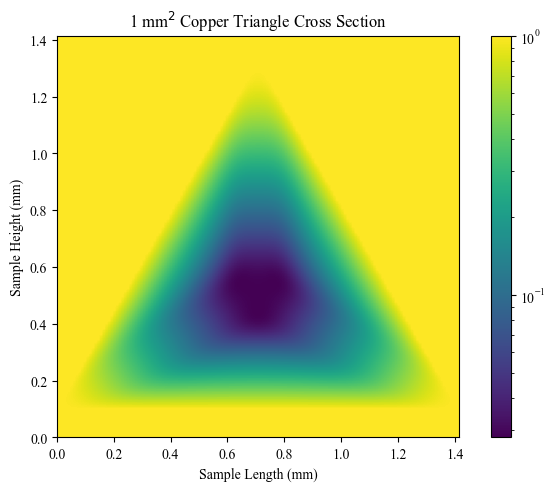

In [2]:
# Triangle plot

tri_resolution = 150
iter = 7500
l = 2**(.5)*1e-3 #this is the legnth of all the sides of triangle. This will gave an area of 1mm^2
tri_data = np.zeros([tri_resolution,tri_resolution])
diff = int((tri_resolution - (tri_resolution*3**.5)//2)//2)
for i in range(int((tri_resolution*3**.5)//2)):
    for j in range(tri_resolution):
        if i>=3**.5*abs(j-(tri_resolution-1)/2):# or i<=2*abs(j-(tri_resolution-1)/2):
            tri_data[i][j] = 1
tri_data2 = np.zeros([tri_resolution,tri_resolution])
tri_data2[diff:int((tri_resolution*3**.5)//2)+1+diff] = tri_data[:int((tri_resolution*3**.5)//2)+1]

tri_H = get_shape_H_Show_Phase(tri_data2,l,get_skin_depth(2e-8),iter)

fig = plt.figure(constrained_layout = True)
ax = fig.add_subplot(1, 1, 1)

p1 = ax.imshow(np.absolute(tri_H),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=np.absolute(tri_H).min(), vmax=1))#,norm=colors.LogNorm(vmin=min(np.absolute(tri_H )), vmax=1))
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length (mm)')
ax.set_ylabel('Sample Height (mm)')
_ = ax.set_title(r'1 mm$^2$ Copper Triangle Cross Section')

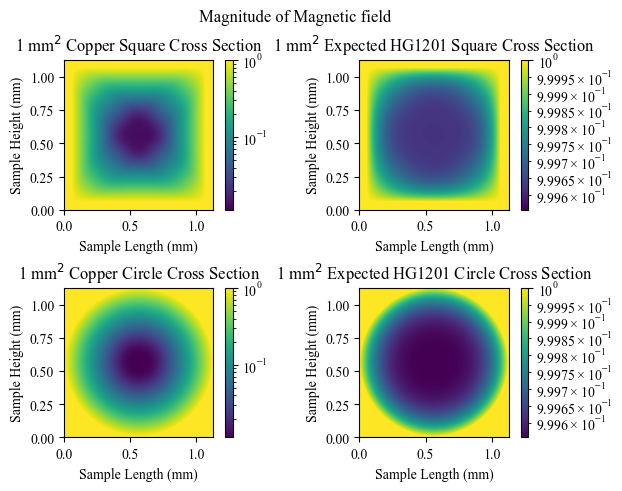

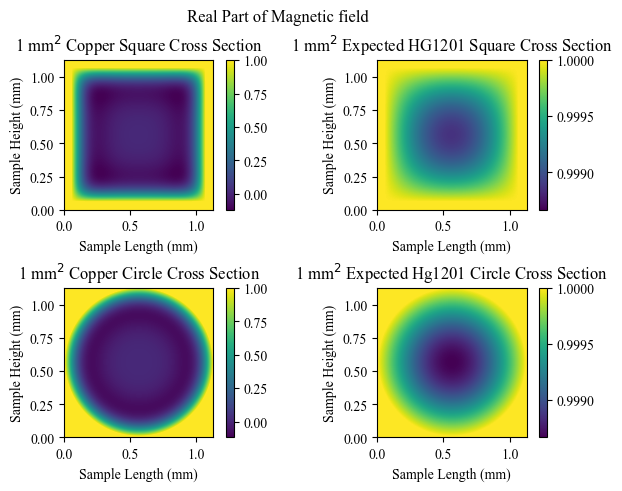

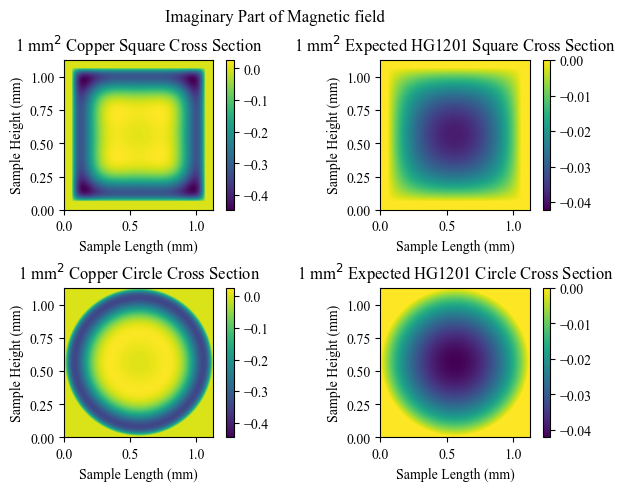

In [3]:
#################################
# Geometry Effects Plotting
#################################

cylind_resolution = 150
square_resolution = 150
s = 1e-3 # length in meters
d = 2e-3/np.pi**.5 #diameter in meters

rho = np.array([2e-8,1000e-8]) #resistivities in ohm*m
skin_depths = get_skin_depth(rho)
CopperSquare = get_square_H(s,skin_depths[0],square_resolution)
CopperCylind = get_cylind_H(d,skin_depths[0],cylind_resolution)
InsolSquare = get_square_H(s,skin_depths[1],square_resolution)
InsolCylind = get_cylind_H(d,skin_depths[1],cylind_resolution)

CopperSquare_ad = adjustsize(CopperSquare,1,2/np.pi**.5,square_resolution,1)
InsolSquare_ad = adjustsize(InsolSquare,1,2/np.pi**.5,square_resolution,1)

# old = CopperSquare[len(CopperSquare)//2][0]
# count = 0
# print(CopperSquare[len(CopperSquare)//2])
# for i, a in enumerate(CopperSquare[len(CopperSquare)//2]):
#     if old == a[i]:
#         count+=1
#     elif old%1 ==0:
#         print(count)
#         count = 0
#     old = a[i]
# print(count)

coppermin = min(np.absolute(CopperSquare).min(),np.absolute(CopperCylind).min())
insolmin = min(np.absolute(InsolSquare).min(),np.absolute(InsolCylind).min())


fig = plt.figure(constrained_layout = True)
ax = fig.add_subplot(2, 2, 1)
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)
fig.suptitle('Magnitude of Magnetic field')

p1 = ax.imshow(np.absolute(CopperSquare_ad),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length (mm)')
ax.set_ylabel('Sample Height (mm)')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.absolute(InsolSquare_ad),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=insolmin, vmax=1))
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length (mm)')
bx.set_ylabel('Sample Height (mm)')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.absolute(CopperCylind),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length (mm)')
cx.set_ylabel('Sample Height (mm)')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.absolute(InsolCylind),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=insolmin, vmax=1))
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length (mm)')
dx.set_ylabel('Sample Height (mm)')
dx.set_title(r'1 mm$^2$ Expected HG1201 Circle Cross Section')
plt.show()

coppermin = min(np.real(CopperSquare).min(),np.real(CopperCylind).min())
insolmin = min(np.real(InsolSquare).min(),np.real(InsolCylind).min())
coppermax = max(np.real(CopperSquare).max(),np.real(CopperCylind).max())
insolmax = min(np.real(InsolSquare).max(),np.real(InsolCylind).max())

fig = plt.figure(constrained_layout = True)
fig.suptitle('Real Part of Magnetic field')
ax = fig.add_subplot(2, 2, 1)
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)

p1 = ax.imshow(np.real(CopperSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length (mm)')
ax.set_ylabel('Sample Height (mm)')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.real(InsolSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length (mm)')
bx.set_ylabel('Sample Height (mm)')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.real(CopperCylind),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length (mm)')
cx.set_ylabel('Sample Height (mm)')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.real(InsolCylind),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length (mm)')
dx.set_ylabel('Sample Height (mm)')
dx.set_title(r'1 mm$^2$ Expected Hg1201 Circle Cross Section')
plt.show()

coppermin = min(np.imag(CopperSquare).min(),np.imag(CopperCylind).min())
insolmin = min(np.imag(InsolSquare).min(),np.imag(InsolCylind).min())
coppermax  = max(np.imag(CopperSquare).max(),np.imag(CopperCylind).max())
insolmax = max(np.imag(InsolSquare).max(),np.imag(InsolCylind).max())

fig = plt.figure(constrained_layout = True)
fig.suptitle('Imaginary Part of Magnetic field')
ax = fig.add_subplot(2, 2, 1)
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)

p1 = ax.imshow(np.imag(CopperSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length (mm)')
ax.set_ylabel('Sample Height (mm)')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.imag(InsolSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length (mm)')
bx.set_ylabel('Sample Height (mm)')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.imag(CopperCylind),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length (mm)')
cx.set_ylabel('Sample Height (mm)')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.imag(InsolCylind),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length (mm)')
dx.set_ylabel('Sample Height (mm)')
dx.set_title(r'1 mm$^2$ Expected HG1201 Circle Cross Section')

plt.show()

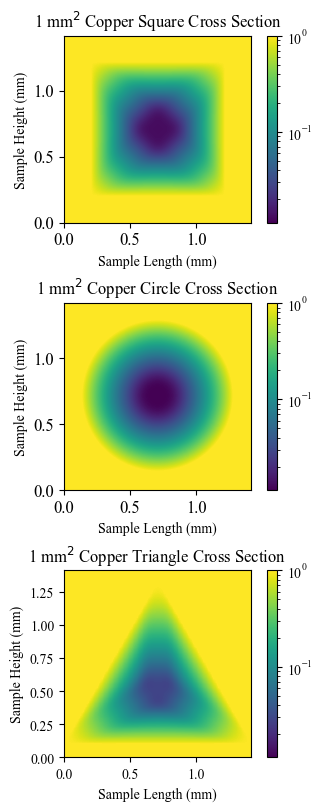

In [4]:
CopperSquare_ad = adjustsize(CopperSquare,s,l,square_resolution,1)
CopperCylind_ad = adjustsize(CopperCylind,d,l,cylind_resolution,1)

coppermin = min(np.absolute(CopperSquare).min(),np.absolute(CopperCylind).min(),np.absolute(tri_H).min())

fig = plt.figure(constrained_layout = True,figsize=(4,8))
ax = fig.add_subplot(3, 1, 1)
bx = fig.add_subplot(3, 1, 2)
cx = fig.add_subplot(3, 1, 3)
p1 = ax.imshow(np.absolute(CopperSquare_ad),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length (mm)')
ax.set_ylabel('Sample Height (mm)')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

p2 = bx.imshow(np.absolute(CopperCylind_ad),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length (mm)')
bx.set_ylabel('Sample Height (mm)')
bx.set_title(r'1 mm$^2$ Copper Circle Cross Section')
bx.tick_params(axis='x', labelsize=12)
bx.tick_params(axis='y', labelsize=12)

p3 = cx.imshow(np.absolute(tri_H),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length (mm)')
cx.set_ylabel('Sample Height (mm)')
_ = cx.set_title(r'1 mm$^2$ Copper Triangle Cross Section')

In [5]:
########################################
# Magnetic Susecptibility v Resistivity
########################################

rhos = np.logspace(-9,-4,100)
chis = np.zeros(len(rhos),dtype=np.complex_) #Stores the effective magnetic susceptibility of cylinder
chis2 = np.zeros(len(rhos),dtype=np.complex_) #square
analchis = np.zeros(len(rhos),dtype=np.complex_)#analytical solution for cylinder
s = 1e-3 # length in meters
d = 2e-3/np.pi**.5 #diameter in meters
a=d/2 #radius

resolution = 150
H0 = 1
for i, rho in enumerate(rhos):
    delta = get_skin_depth(rho)
    k =(1-1j)/delta
    cylind = get_cylind_H(d,delta,resolution)
    Square = get_square_H(s,delta,resolution)
    chis[i] = double_Integral(cylind,d)/d**2-1
    chis2[i] = double_Integral(Square,s)/s**2-1
    analchis[i] = 2/a/k*jv(1,a*k)/jv(0,a*k)-1
Phase2Resistivty = interp1d(np.angle(analchis),rhos) #this is the big headline. Now we can convert a measured phase to resistivity


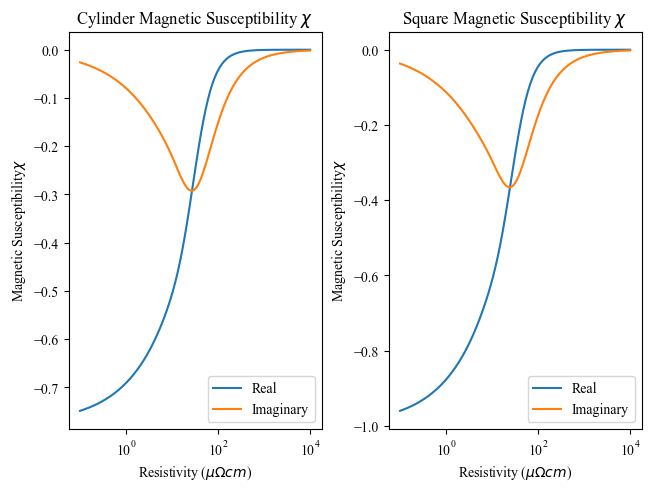

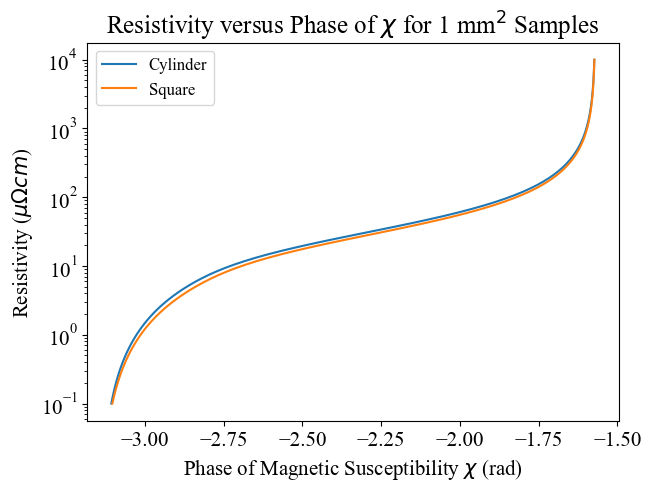

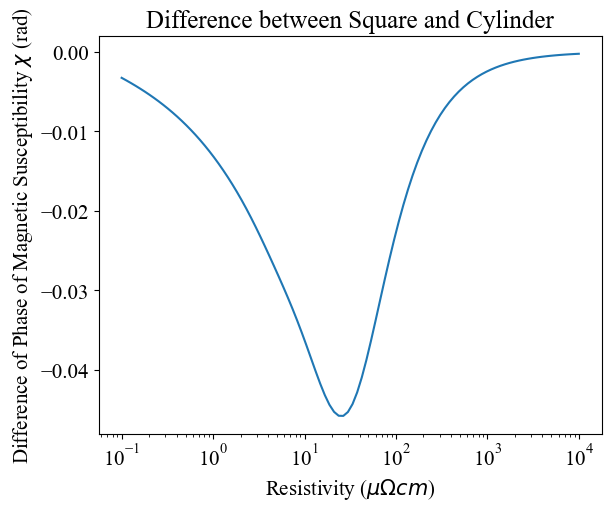

In [6]:
fig1 = plt.figure(constrained_layout = True)
fig2 = plt.figure(constrained_layout = True)
fig3 = plt.figure(constrained_layout = True, figsize=(6, 5))
ax = fig1.add_subplot(1, 2, 1)
bx = fig1.add_subplot(1, 2, 2)
cx = fig2.add_subplot(1, 1, 1)
dx = fig3.add_subplot(1, 1, 1)
ax.plot(rhos*1e8,chis.real)
ax.plot(rhos*1e8,chis.imag)
# ax.plot(rhos*1e8,np.absolute(chis))
ax.set_xscale('log')
ax.set_xlabel(r'Resistivity ($\mu \Omega cm$)')
ax.set_ylabel(r'Magnetic Susceptibility$\chi$')
ax.legend(['Real','Imaginary','Magnitude'])
ax.set_title(r'Cylinder Magnetic Susceptibility $\chi$')

bx.plot(rhos*1e8,chis2.real)
bx.plot(rhos*1e8,chis2.imag)
# bx.plot(rhos*1e8,np.absolute(chis2))
bx.set_xscale('log')
bx.set_xlabel(r'Resistivity ($\mu \Omega cm$)')
bx.set_ylabel(r'Magnetic Susceptibility$\chi$')
bx.legend(['Real','Imaginary','Magnitude'])
bx.set_title(r'Square Magnetic Susceptibility $\chi$')

cx.plot(np.angle(chis),rhos*1e8)
cx.plot(np.angle(chis2),rhos*1e8)
cx.set_yscale('log')
cx.set_ylabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
cx.set_xlabel(r'Phase of Magnetic Susceptibility $\chi$ (rad)',fontsize = 15)
cx.set_title(r'Resistivity versus Phase of $\chi$ for 1 mm$^2$ Samples',fontsize = 18)
cx.legend(['Cylinder','Square'], fontsize=12)
cx.tick_params(axis='x', labelsize=15)
cx.tick_params(axis='y', labelsize=15)

dx.plot(rhos*1e8,np.angle(chis)-np.angle(chis2))
dx.set_xscale('log')
dx.set_title('Difference between Square and Cylinder',fontsize = 18)
dx.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
dx.set_ylabel(r'Difference of Phase of Magnetic Susceptibility $\chi$ (rad)',fontsize = 15)
dx.tick_params(axis='x', labelsize=15)
_ = dx.tick_params(axis='y', labelsize=15)

Area Percision Simulation

Simulation Accuracy (Given analytical solution for magnetic field) 

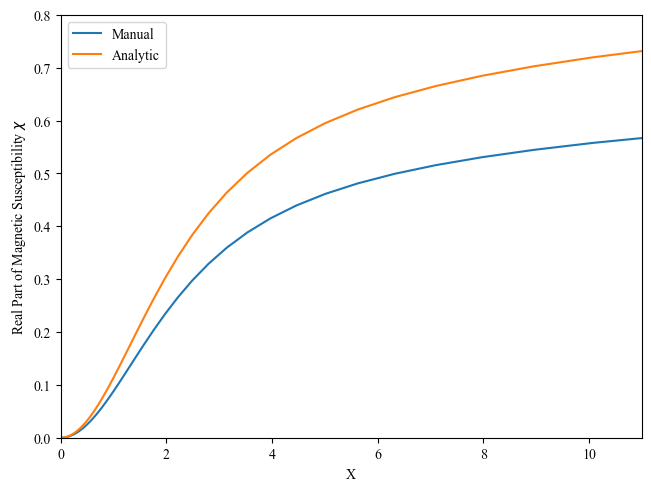

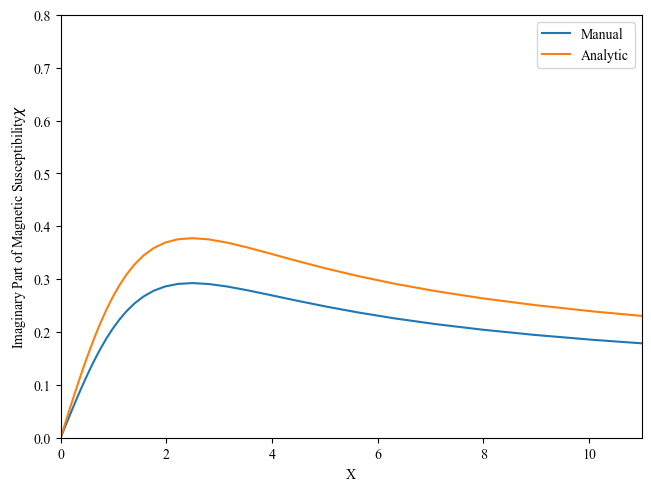

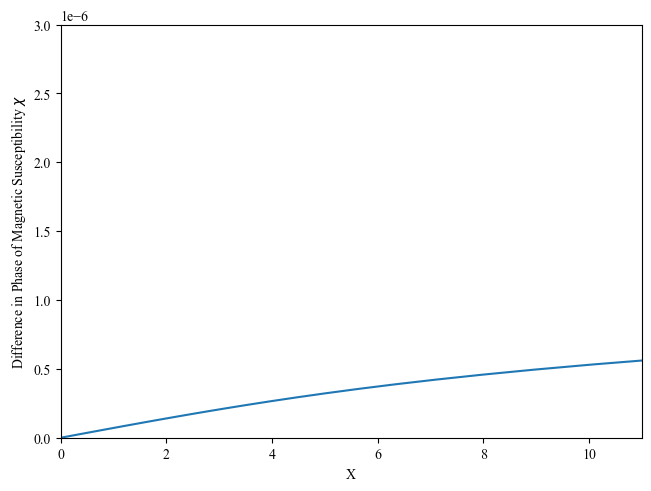

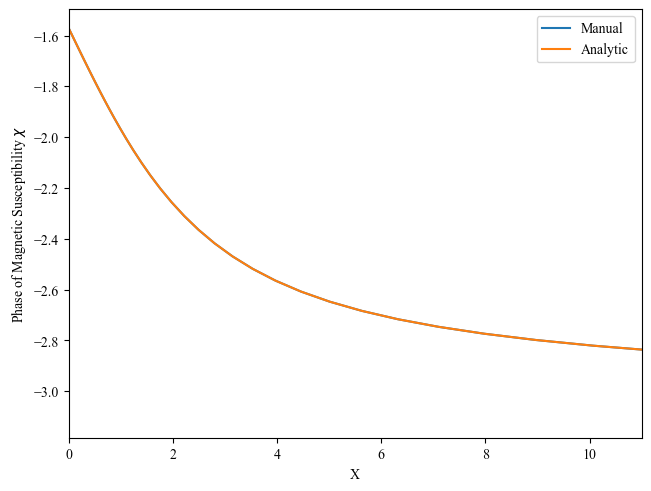

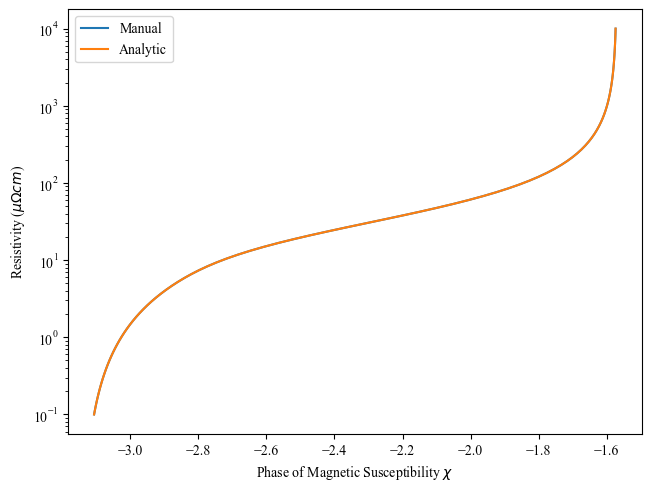

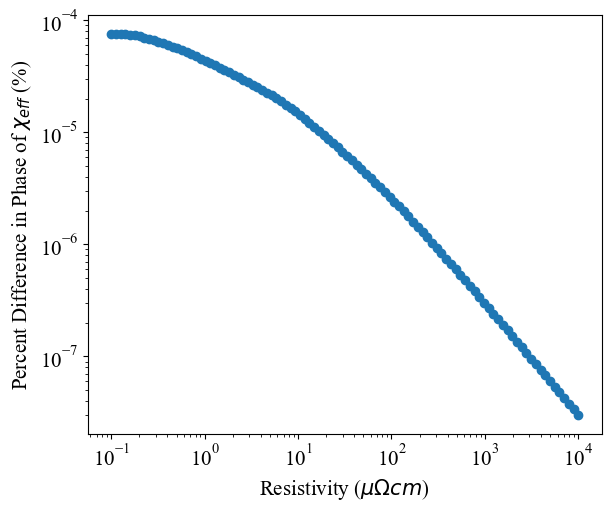

In [8]:
fig1 = plt.figure(constrained_layout = True)
fig2 = plt.figure(constrained_layout = True)
fig3 = plt.figure(constrained_layout = True)
fig4 = plt.figure(constrained_layout = True)
fig5 = plt.figure(constrained_layout = True)
fig6 = plt.figure(constrained_layout = True, figsize= (6,5))
ax = fig1.add_subplot(1, 1, 1)
bx = fig2.add_subplot(1, 1, 1)
cx = fig3.add_subplot(1, 1, 1)
dx = fig4.add_subplot(1, 1, 1)
ex = fig5.add_subplot(1, 1, 1)
fx = fig6.add_subplot(1, 1, 1)
r = .5e-3
X = (r/get_skin_depth(rhos))**2
ax.plot(X,-chis.real)
ax.plot(X,-analchis.real)
ax.set_xlabel(r'X')
ax.set_ylabel(r'Real Part of Magnetic Susceptibility $\chi$')
ax.legend(['Manual','Analytic'])
ax.set_xlim(0,11)
ax.set_ylim(0,.8)

bx.plot(X,-chis.imag)
bx.plot(X,-analchis.imag)
bx.set_xlabel(r'X')
bx.set_ylabel(r'Imaginary Part of Magnetic Susceptibility$\chi$')
bx.legend(['Manual','Analytic'])
bx.set_xlim(0,11)
bx.set_ylim(0,.8)

cx.plot(X,np.angle(analchis)-np.angle(chis))
# cx.plot(X,np.angle(analchis))
cx.set_xlabel(r'X')
cx.set_ylabel(r'Difference in Phase of Magnetic Susceptibility $\chi$')
cx.set_xlim(0,11)
cx.set_ylim(0,3e-6)

dx.plot(X,np.angle(chis))
dx.plot(X,np.angle(analchis))
dx.set_xlabel(r'X')
dx.set_ylabel(r'Phase of Magnetic Susceptibility $\chi$')
dx.legend(['Manual','Analytic'])
dx.set_xlim(0,11)

ex.plot(np.angle(chis),rhos*1e8)
ex.plot(np.angle(analchis),rhos*1e8)
ex.set_yscale('log')
ex.set_ylabel(r'Resistivity ($\mu \Omega cm$)')
ex.set_xlabel(r'Phase of Magnetic Susceptibility $\chi$')
ex.legend(['Manual','Analytic'])

# fx.set_title(r'Difference in Phase of $\chi$ between FEA and Analytical',fontsize = 18)
fx.scatter(rhos*1e8,100*(np.angle(chis)-np.angle(analchis))/np.angle(analchis))
fx.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
fx.set_ylabel(r'Percent Difference in Phase of $\chi_{eff}$ (%)',fontsize = 15)
# fx.set_yscale('log')
fx.set_xscale('log')
fx.set_yscale('log')
fx.tick_params(axis='x', labelsize=15)
fx.tick_params(axis='y', labelsize=15)
# fx.legend(['Manual','Analytic'])

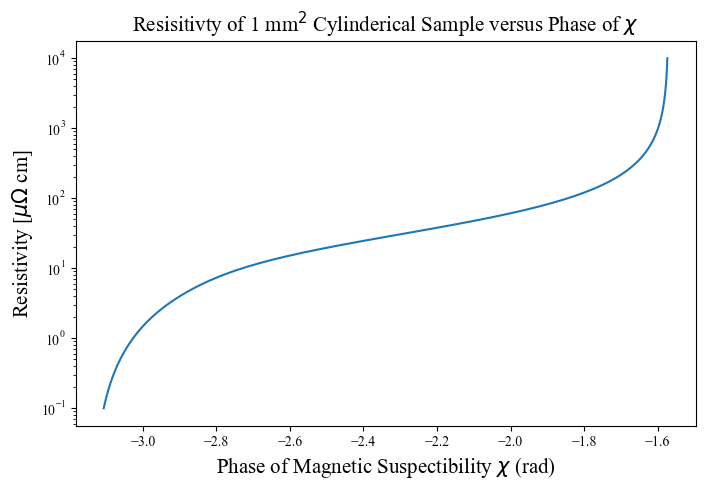

In [9]:

fig,cx = plt.subplots(1,1,figsize = (8,5))
# bx = fig.add_subplot(2, 1, 2)
cx.plot(np.angle(chis),rhos*1e8)
cx.set_ylabel(r"Resistivity [$\mu \Omega$ cm]",fontsize=15)
cx.set_xlabel(r"Phase of Magnetic Suspectibility $\chi$ (rad)",fontsize=15)
cx.set_title(r'Resisitivty of 1 mm$^2$ Cylinderical Sample versus Phase of $\chi$',fontsize=15)
# cx.tick_params(axis='x', labelsize=15)
# cx.tick_params(axis='y', labelsize=15)
# cx.set_xscale('log')
cx.set_yscale('log')
# cx.set_xticks(np.arange(min(abs(np.angle(chis))), max(abs(np.angle(chis))), step=0.2))
# ax.set_xlim([min(rhos),max(rhos)])
# ax.set_ylim([0,max(-chis.real)])
# ax.legend(['Real','Imaginary','Magnitude'])

In [10]:
# Analytic Solution Sanity Check
# Define the parameters
rho = 5e-6  # resistivity
spacial_res = 250
iter = 100000
r = .5e-3  # define the radius of the circle
r = np.sqrt(2e-6/np.pi)
d=2*r

# Set the circular mask
mask = np.zeros((spacial_res+2, spacial_res+2))  # initialize the mask
for i in range(1,spacial_res+1):
    for j in range(1,spacial_res+1):
        if np.sqrt((i-(spacial_res+1)/2)**2 + (j-(spacial_res+1)/2)**2)*2 <= spacial_res: #this makes a circle
            mask[i, j] = 1 # ouinside is ones

# z = better_guess(mask,d,get_skin_depth(rho))
z = np.ones((spacial_res+2, spacial_res+2), dtype=np.complex128)

# z_2 = z.copy()

phases = np.zeros(iter)
phases_2 = np.zeros(iter)
skin_depth = get_skin_depth(rho)
k_squared = -2j / (skin_depth)**2 
k = (1 - 1j) / skin_depth
dx = d/(spacial_res+1)
# dx_2 = d/(spacial_res+2)
inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
# inv_denom_2 = 1/(4 - k_squared * dx_2**2) #limit repeated calculations

# Time to iterate
for n in range(iter):
    for i in range(1, spacial_res + 1):  # loop over the interior points in x
        for j in range(1, spacial_res + 1):  # loop over the interior points in y
            if mask[i, j] == 1:  # check if the current point is in the interior
                #update the current point using the finite difference method
                z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
                # z_2[i, j] = (z_2[i+1, j] + z_2[i-1, j] + z_2[i, j+1] + z_2[i, j-1]) * inv_denom_2
    phases[n] = np.angle(double_Integral(z,d)/d**2-1)
    # phases_2[n] = np.angle(double_Integral(z_2,d)/d**2-1)

# z = get_shape_H(mask,2*r,get_skin_depth(rho),iter)
i1 = np.logical_not(phases<0)
phases[i1]-= 2*np.pi



-1.6824680307263302 -1.6827190940874064 0.0002510633610761648
error


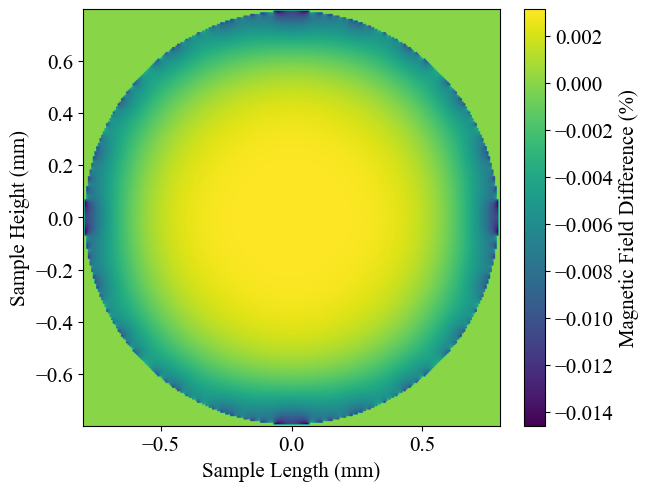

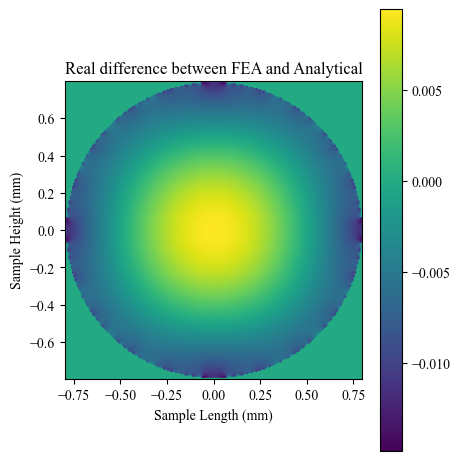

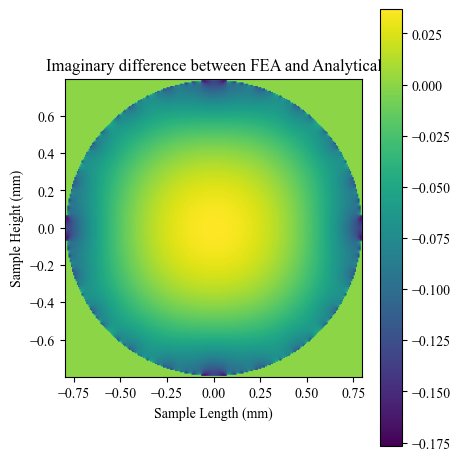

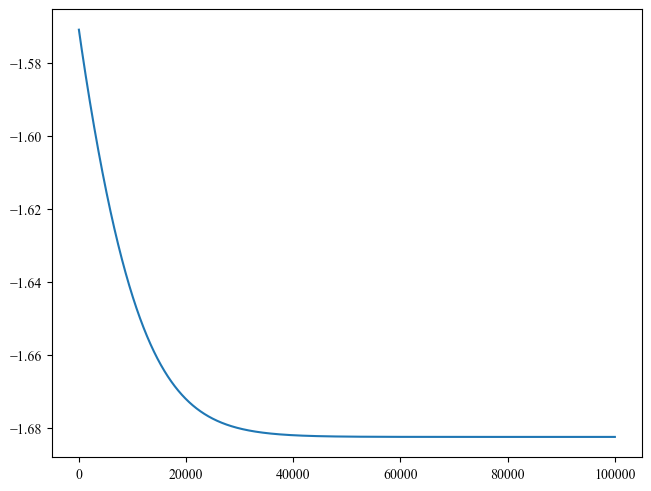

In [11]:
analytic = get_cylind_H(2*r,get_skin_depth(rho),spacial_res)#magnetic field analytic

chi = double_Integral(z,d)/d**2-1 #find the phase of the simulated field
# chi_2 = double_Integral(z_2,d)/d**2-1 #find the phase of the simulated field
k =(1-1j)/get_skin_depth(rho)
anachi = 2/r/k*jv(1,r*k)/jv(0,r*k)-1
print(np.angle(chi),np.angle(anachi),np.angle(chi)-np.angle(anachi))
# print(np.angle(chi_2),np.angle(anachi),np.angle(chi_2)-np.angle(anachi))
plt.close('all')

# get interpolatoion fucniton
rhos3 = np.logspace(-9,-6,1000)
analchis = np.zeros(len(rhos3),dtype=np.complex_)#analytical solution for cylinder
for i, rho1 in enumerate(rhos3):
    k =(1-1j)/get_skin_depth(rho1)
    analchis[i] = 2/r/k*jv(1,r*k)/jv(0,r*k)-1
    
try:   
    Phase2Resistivty2 = interp1d(np.angle(analchis),rhos3)
    print(rho,Phase2Resistivty2(np.angle(chi)))
except:
    print('error')


figa = plt.figure(constrained_layout = True)
axa = figa.add_subplot(1, 1, 1)
p = axa.imshow(100*(np.absolute(z)-np.absolute(analytic)),extent=1e3*np.array([-d/2, d/2, -d/2, d/2]))
cb = figa.colorbar(p, ax=axa)
cb.ax.tick_params(labelsize=15)
cb.set_label('Magnetic Field Difference (%)', fontsize=15)
axa.set_xlabel('Sample Length (mm)',fontsize=15)
axa.set_ylabel('Sample Height (mm)',fontsize=15)
axa.tick_params(axis='x', labelsize=15)
axa.tick_params(axis='y', labelsize=15)
# axa.set_title(r'Absolute difference between FEA and Analytical')

figb = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
axb = figb.add_subplot(1, 1, 1)
p = axb.imshow(100*(np.real(z)-np.real(analytic)),extent=1e3*np.array([-d/2, d/2, -d/2, d/2]))
figb.colorbar(p, ax=axb)
axb.set_xlabel('Sample Length (mm)')
axb.set_ylabel('Sample Height (mm)')
axb.set_title(r'Real difference between FEA and Analytical')

figc = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
axc = figc.add_subplot(1, 1, 1)
p = axc.imshow(100*(np.imag(z)-np.imag(analytic)),extent=1e3*np.array([-d/2, d/2, -d/2, d/2]))
figc.colorbar(p, ax=axc)
axc.set_xlabel('Sample Length (mm)')
axc.set_ylabel('Sample Height (mm)')

axc.set_title(r'Imaginary difference between FEA and Analytical')

fig = plt.figure(constrained_layout = True)
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(iter),phases)


Repeat, but with Phase of Chi

In [12]:
# Analytic Solution Sanity Check
# Define the parameters
rhos5 = np.logspace(-6.5,-4,40)
spacial_res = 250
iter = 10000
r = .5e-3  # define the radius of the circle
r = np.sqrt(2e-6/np.pi)
d=2*r

# Set the circular mask
mask = np.zeros((spacial_res+2, spacial_res+2))  # initialize the mask
for i in range(1,spacial_res+1):
    for j in range(1,spacial_res+1):
        if np.sqrt((i-(spacial_res+1)/2)**2 + (j-(spacial_res+1)/2)**2)*2 <= spacial_res: #this makes a circle
            mask[i, j] = 1 # ouinside is ones




phases = np.zeros((len(rhos5),iter))
for m, rho in enumerate(rhos5):
    z = better_guess(mask,d,get_skin_depth(rho))
    skin_depth = get_skin_depth(rho)
    k_squared = -2j / (skin_depth)**2 
    k = (1 - 1j) / skin_depth
    dx = d/(spacial_res+1)
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations

    # Time to iterate
    for n in range(iter):
        for i in range(1, spacial_res + 1):  # loop over the interior points in x
            for j in range(1, spacial_res + 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
        phases[m][n] = np.angle(double_Integral(z,d)/d**2-1)


i1 = np.logical_not(phases<0)
phases[i1]-= 2*np.pi



fit spacial d from phase

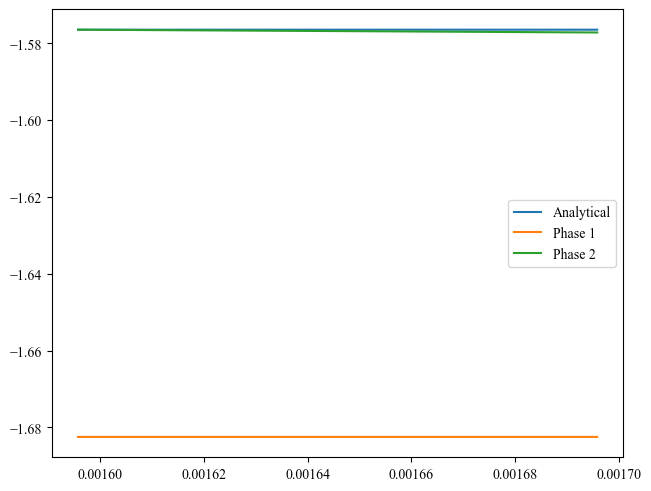

In [ ]:
#find best d fit for phase
guess_half_width = .1e-3
ds = np.linspace(d-guess_half_width,d+guess_half_width,10000)
rs = ds/2
k =(1-1j)/get_skin_depth(rho)
anachi = 2/r/k*jv(1,r*k)/jv(0,r*k)-1
fig4 = plt.figure(constrained_layout = True)
ax = fig4.add_subplot(1, 1, 1)
low = np.min([np.angle(chi),np.angle(anachi)])# ,np.angle(chi_2)
top = np.max([np.angle(chi),np.angle(anachi)])
anaphases = np.angle(2/rs/k*jv(1,rs*k)/jv(0,rs*k)-1)
i = np.logical_and(anaphases>low,anaphases<top)
ax.plot(ds[i],[np.angle(anachi)]*len(ds[i]))
ax.plot(ds[i],[np.angle(chi)]*len(ds[i]))
# ax.plot(ds[i],[np.angle(chi_2)]*len(ds[i]))
ax.plot(ds[i],anaphases[i])
_ = ax.legend(['Analytical','Phase 1','Phase 2','Radius/Phase Line'])
#200 pixels effective diamter is 1.003mm
#150 pixels effect diamtete is 1.005mm
#100 pixel effec diamter = 1.006mm

Square Test

In [ ]:
# Analytic Solution Sanity Check
# Define the parameters
rho = 1e-7  # resistivity
spacial_res = 100
iter = 15000
r = .5e-3  # define the radius of the circle
d=2*r

# Set the circular mask
mask = np.ones((spacial_res+2, spacial_res+2))  # initialize the mask to ones
mask[0] = np.array([0]*len(mask))
mask[-1] = np.array([0]*len(mask))
tmask = np.transpose(mask)
tmask[0] = np.array([0]*len(mask))
tmask[-1] = np.array([0]*len(mask))
mask = np.transpose(tmask)

# fig = plt.figure(constrained_layout = True)
# ax = fig.add_subplot(1, 1, 1)
# ax.imshow(mask)

z = better_guess(mask,d,get_skin_depth(rho))
# z_2 = z.copy()

phases = np.zeros(iter)
phases_2 = np.zeros(iter)
skin_depth = get_skin_depth(rho)
k_squared = -2j / (skin_depth)**2 
k = (1 - 1j) / skin_depth
dx = d/(spacial_res+1)
# dx_2 = d/(spacial_res+2)
inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
# inv_denom_2 = 1/(4 - k_squared * dx_2**2) #limit repeated calculations

# Time to iterate
for n in range(iter):
    for i in range(1, spacial_res + 1):  # loop over the interior points in x
        for j in range(1, spacial_res + 1):  # loop over the interior points in y
            if mask[i, j] == 1:  # check if the current point is in the interior
                #update the current point using the finite difference method
                z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
                # z_2[i, j] = (z_2[i+1, j] + z_2[i-1, j] + z_2[i, j+1] + z_2[i, j-1]) * inv_denom_2
    phases[n] = np.angle(double_Integral(z,d)/d**2-1)
    # phases_2[n] = np.angle(double_Integral(z_2,d)/d**2-1)

-2.693052651921151 -2.693052653270002 1.3488508088244089e-09


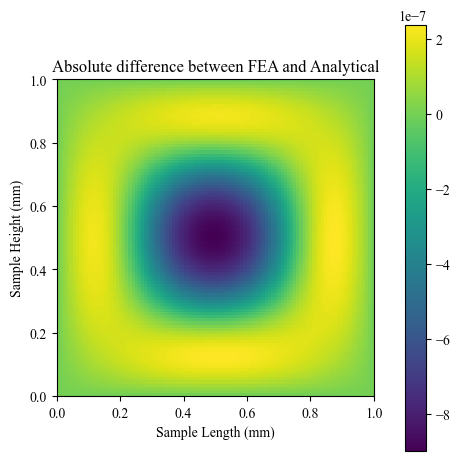

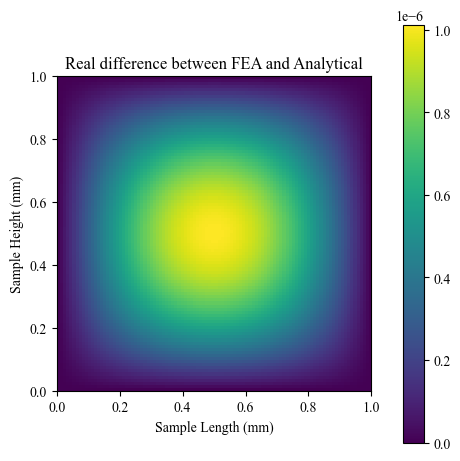

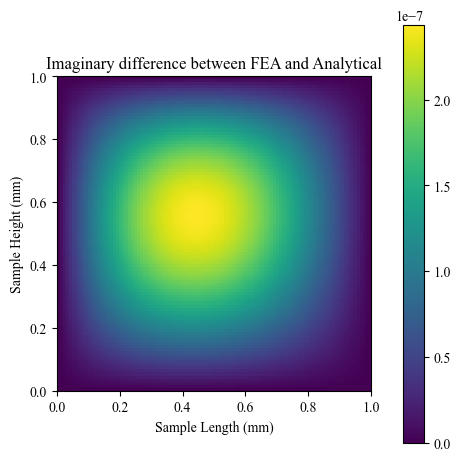

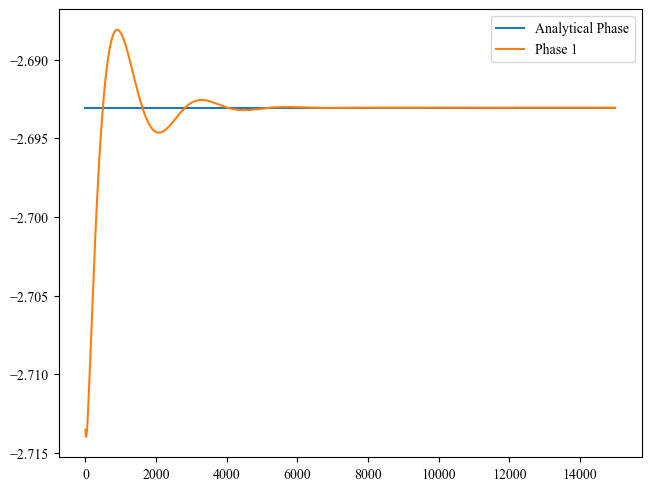

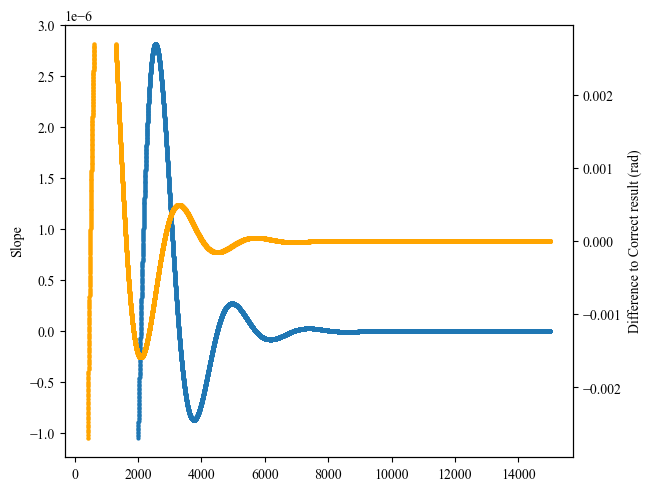

In [ ]:
analytic = get_square_H(2*r,get_skin_depth(rho),spacial_res)#magnetic field analytic
# analytic_2 = get_square_H_2(2*r,get_skin_depth(rho),spacial_res)#magnetic field analytic
anachi = double_Integral(analytic,d)/d**2-1
# anachi_2 = double_Integral(analytic_2,d)/d**2-1
chi = double_Integral(z,d)/d**2-1 #find the phase of the simulated field
# chi_2 = double_Integral(z_2,d)/d**2-1 #find the phase of the simulated field

print(np.angle(chi),np.angle(anachi),np.angle(chi)-np.angle(anachi))
# print(np.angle(chi),np.angle(anachi_2),np.angle(chi)-np.angle(anachi_2))


# # get interpolatoion fucniton
# rhos3 = np.logspace(-9,-6,1000)
# analchis = np.zeros(len(rhos3),dtype=np.complex_)#analytical solution for cylinder
# for i, rho1 in enumerate(rhos3):
#     k =(1-1j)/get_skin_depth(rho1)
#     analchis[i] = 2/r/k*jv(1,r*k)/jv(0,r*k)-1
    
# try:   
#     Phase2Resistivty2 = interp1d(np.angle(analchis),rhos3)
#     print(rho,Phase2Resistivty2(np.angle(chi)))
# except:
#     print('error')


figa = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
axa = figa.add_subplot(1, 1, 1)
p = axa.imshow(100*(np.absolute(z)-np.absolute(analytic)),extent=[0, 1, 0, 1])
figa.colorbar(p, ax=axa)
axa.set_xlabel('Sample Length (mm)')
axa.set_ylabel('Sample Height (mm)')
axa.set_title(r'Absolute difference between FEA and Analytical')

figb = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
axb = figb.add_subplot(1, 1, 1)
p = axb.imshow(100*(np.real(z)-np.real(analytic)),extent=[0, 1, 0, 1])
figb.colorbar(p, ax=axb)
axb.set_xlabel('Sample Length (mm)')
axb.set_ylabel('Sample Height (mm)')
axb.set_title(r'Real difference between FEA and Analytical')

figc = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
axc = figc.add_subplot(1, 1, 1)
p = axc.imshow(100*(np.imag(z)-np.imag(analytic)),extent=[0, 1, 0, 1])
figc.colorbar(p, ax=axc)
axc.set_xlabel('Sample Length (mm)')
axc.set_ylabel('Sample Height (mm)')
axc.set_title(r'Imaginary difference between FEA and Analytical')

fig3 = plt.figure(constrained_layout = True)
cx = fig3.add_subplot(1, 1, 1)
cx.plot([0,iter],[np.angle(anachi),np.angle(anachi)])
# cx.plot([0,iter],[np.angle(anachi_2),np.angle(anachi_2)])
cx.plot(np.arange(iter),phases)
# cx.plot(np.arange(iter),phases_2)
# cx.plot(np.arange(iter),bestpars1[0] *np.exp(-bestpars1[4]*np.arange(iter))*np.cos(2*np.pi*np.arange(iter)/bestpars1[1]+bestpars1[2])+bestpars1[3])

# cx.plot([0,iter],[-np.pi,-np.pi])
cx.legend(['Analytical Phase','Phase 1'])

ind50 = np.logical_not(abs((phases-np.angle(anachi))/np.angle(anachi))>0.001)
ind51 = np.logical_and(abs((phases-np.angle(anachi))/np.angle(anachi))<0.001, np.arange(iter)>2000)

fig4 = plt.figure(constrained_layout = True)
dx = fig4.add_subplot(1, 1, 1)
dx.scatter(np.arange(iter)[ind51],np.gradient(phases)[ind51],s=4)
dx.set_ylabel('Slope')
ex = dx.twinx()
ex.scatter(np.arange(iter)[ind50],(phases-np.angle(anachi))[ind50],color = 'orange',s = 5)
_ = ex.set_ylabel('Difference to Correct result (rad)')


Comparison to 2-D object

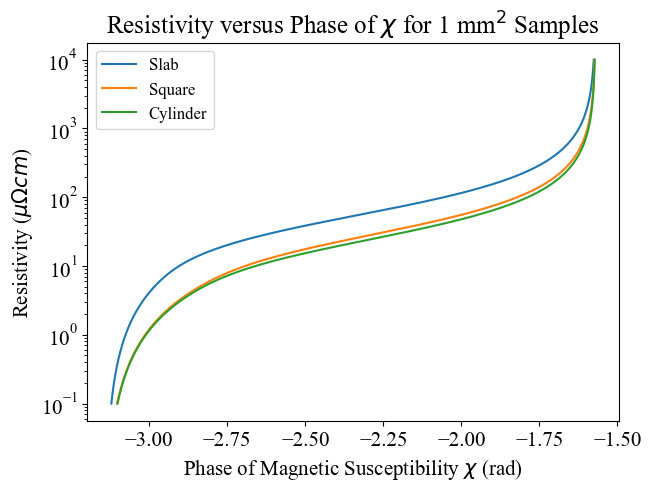

In [ ]:
rhos = np.logspace(-9,-4,1000)
chis = np.zeros(len(rhos),dtype=np.complex_) #Stores the effective magnetic susceptibility of a slab
chis2 = np.zeros(len(rhos),dtype=np.complex_) #square
analchis = np.zeros(len(rhos),dtype=np.complex_)#analytical solution for cylinder

s = 1e-3 # length in meters
#i found another analytical solution when to ∇^2H = -kH: when ∇^2H =d^2 H/(dx^2) (or the sample is so thin that is has no change in field across its y axis and it is so thick, there is no change along the z)
resolution = 150
for i, rho in enumerate(rhos):
    delta = get_skin_depth(rho)
    Square = get_square_H(s,delta,resolution)
    chis2[i] = double_Integral(Square,s)/s**2-1
    chis[i] = delta/s*(np.sinh(s/delta)+np.sin(s/delta))/(np.cosh(s/delta)+np.cos(s/delta))-1+1j*delta/s*(np.sinh(s/delta)-np.sin(s/delta))/(np.cosh(s/delta)+np.cos(s/delta))
    k =(1-1j)/delta
    analchis[i] = 2/r/k*jv(1,r*k)/jv(0,r*k)-1
fig2 = plt.figure(constrained_layout = True)

cx = fig2.add_subplot(1, 1, 1)
cx.plot(-np.angle(chis),rhos*1e8)
cx.plot(np.angle(chis2),rhos*1e8)
cx.plot(np.angle(analchis),rhos*1e8)
cx.set_yscale('log')
cx.set_ylabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
cx.set_xlabel(r'Phase of Magnetic Susceptibility $\chi$ (rad)',fontsize = 15)
cx.set_title(r'Resistivity versus Phase of $\chi$ for 1 mm$^2$ Samples',fontsize = 18)
cx.legend(['Slab','Square','Cylinder'], fontsize=12)
cx.tick_params(axis='x', labelsize=15)
cx.tick_params(axis='y', labelsize=15)


Plot Magnetic Field Convergence

In [ ]:
# Analytic Solution Sanity Check
# Define the parameters
rho = 1e-5  # resistivity
spacial_res = 100
iter = 5000
r = 1e-3  # define the radius of the circle
d=2*r

# Set the circular mask
mask = np.zeros((spacial_res+2, spacial_res+2))  # initialize the mask
for i in range(1,spacial_res+1):
    for j in range(1,spacial_res+1):
        if np.sqrt((i-(spacial_res+1)/2)**2 + (j-(spacial_res+1)/2)**2)*2 <= spacial_res: #this makes a circle
            mask[i, j] = 1 # ouinside is ones

z = better_guess(mask,d,get_skin_depth(rho))
phases = np.zeros(iter)
zs = np.zeros((iter,spacial_res+2,spacial_res+2),dtype=np.complex128)
skin_depth = get_skin_depth(rho)
k_squared = -2j / (skin_depth)**2 
dx = d/(spacial_res+1)
inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations

# Time to iterate
for n in range(iter):
    for i in range(1, spacial_res + 1):  # loop over the interior points in x
        for j in range(1, spacial_res + 1):  # loop over the interior points in y
            if mask[i, j] == 1:  # check if the current point is in the interior
                #update the current point using the finite difference method
                z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
    zs[n] = z
    phases[n] = np.angle(double_Integral(z,d)/d**2-1)
analytic = get_cylind_H(2*r,get_skin_depth(rho),spacial_res)#magnetic field analytic

interactive(children=(IntSlider(value=1, description='iters', max=4999, min=1), Output()), _dom_classes=('widg…

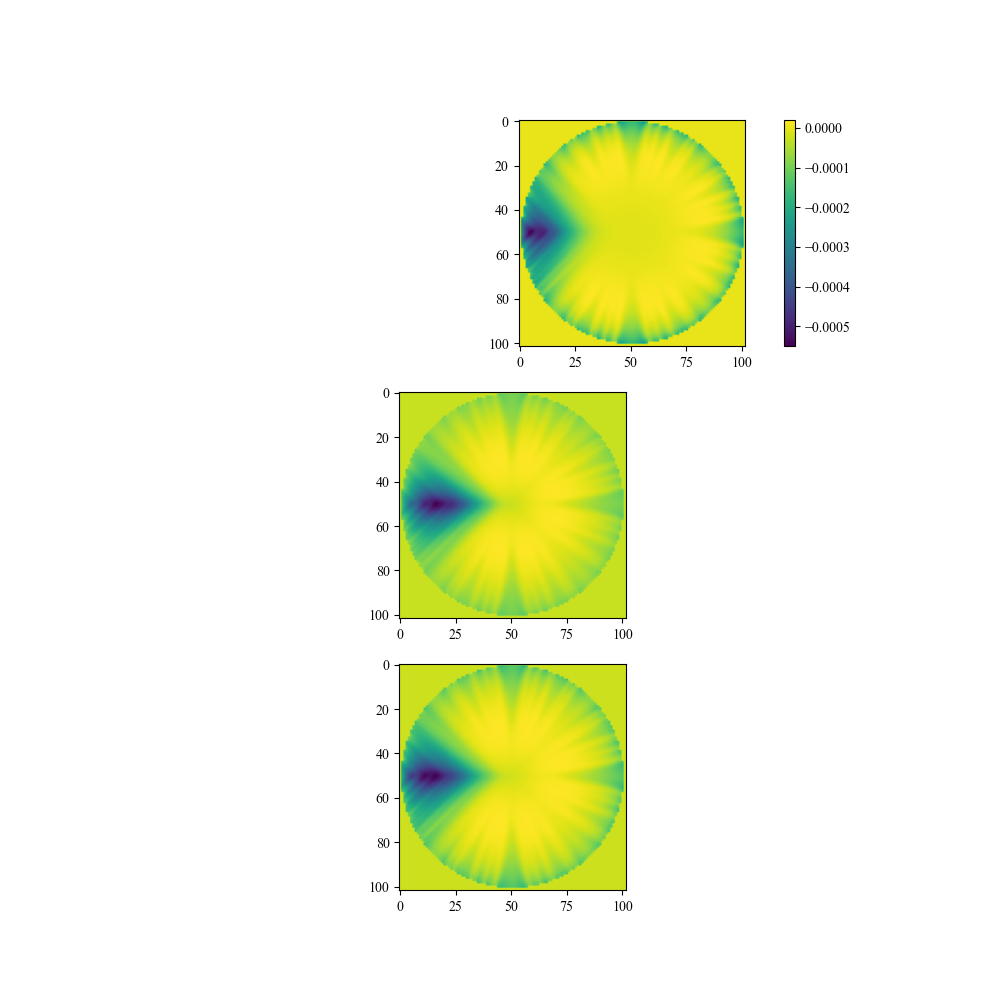

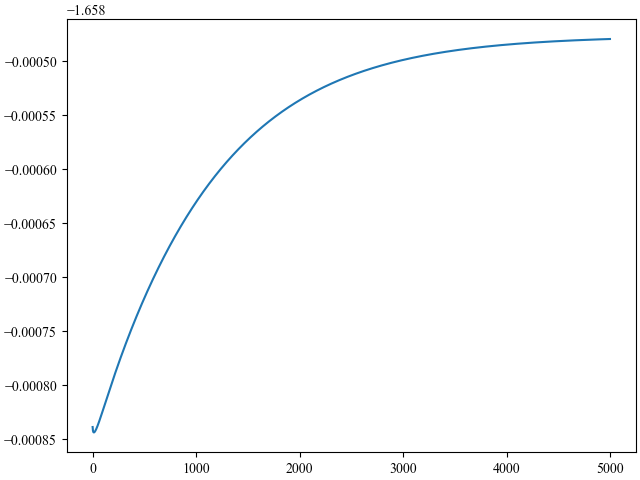

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(3, 1, 1)
bx = fig.add_subplot(3, 1, 2)
cx = fig.add_subplot(3, 1, 3)
fig3 = plt.figure(constrained_layout = True)
dx = fig3.add_subplot(1, 1, 1)
dx.plot(np.arange(iter),phases)
# cx.plot([0,iter],[np.angle(anachi),np.angle(anachi)])
p1 = ax.imshow(np.absolute(zs[0])-np.absolute(analytic))
cb = fig.colorbar(p1, ax=ax)
def update(iters = 0):
    global cb
    if iters != 0:
        print(iters)
        cb.remove()
    p1 = ax.imshow(np.absolute(zs[iters])-np.absolute(analytic))
    cb = fig.colorbar(p1, ax=ax)
    p2 = bx.imshow(np.real(zs[iters])-np.real(analytic))
    p3 = cx.imshow(np.imag(zs[iters])-np.imag(analytic))
     
# ax.imshow(np.absolute(zs[0]))   
interact(update, iters = (1,iter-1,1));

Magnetic Field on Circle versus Frequency

In [ ]:
cb1 = fig.colorbar(p1, ax=ax)
cb2 = fig.colorbar(p1, ax=ax)
cb3 = fig.colorbar(p1, ax=ax)
cb4 = fig.colorbar(p1, ax=ax)
cb5 = fig.colorbar(p1, ax=ax)
cb6 = fig.colorbar(p1, ax=ax)
spacial_res = 150
r = 1e-3  # define the radius of the circle
s = r*np.sqrt(np.pi)
rho_min = 5e-7
rho_max = 1e-4
rhos = np.logspace(np.log10(rho_min),np.log10(rho_max),100)
chis2 = np.zeros(len(rhos),dtype=np.complex_) #square
analchis = np.zeros(len(rhos),dtype=np.complex_)
for i, rho in enumerate(rhos):
    delta = get_skin_depth(rho)
    Square = get_square_H(s,delta,spacial_res)
    chis2[i] = double_Integral(Square,s)/s**2-1
    k =(1-1j)/delta
    analchis[i] = 2/r/k*jv(1,r*k)/jv(0,r*k)-1

interactive(children=(IntSlider(value=50, description='rho', max=10000, min=50), Checkbox(value=False, descrip…

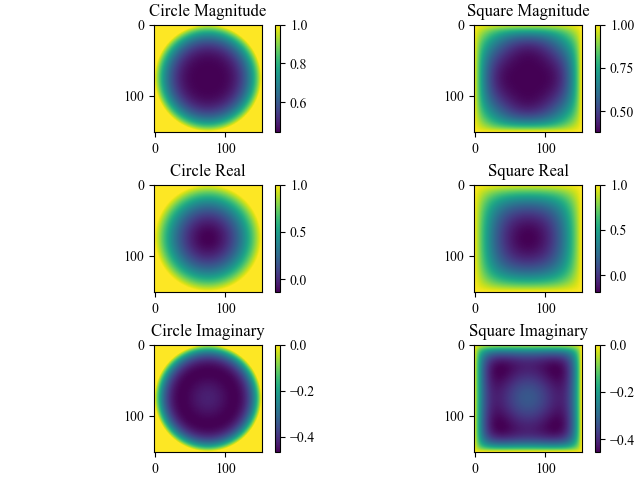

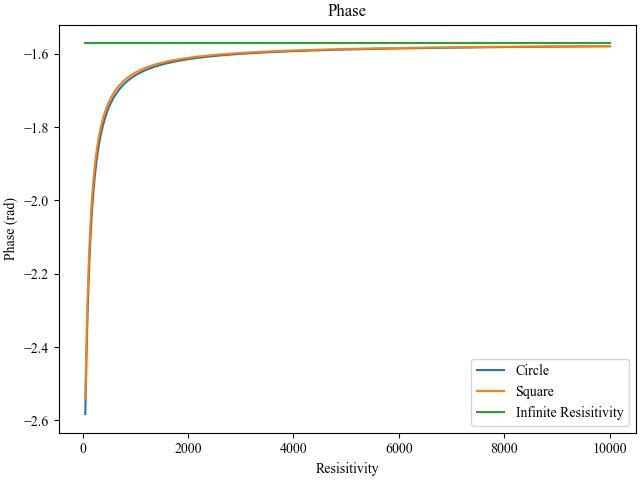

In [ ]:
%matplotlib widget
plt.close('all')
# Define the parameters


fig9 = plt.figure(constrained_layout = True)
fig10 = plt.figure(constrained_layout = True)
ax = fig9.add_subplot(3, 2, 1)
bx = fig9.add_subplot(3, 2, 3)
cx = fig9.add_subplot(3, 2, 5)
dx = fig9.add_subplot(3, 2, 2)
ex = fig9.add_subplot(3, 2, 4)
fx = fig9.add_subplot(3, 2, 6)
gx = fig10.add_subplot(1, 1, 1)
# p1 = ax.imshow(np.absolute(get_cylind_H(2*r,get_skin_depth(1.0101010100101e-8),spacial_res)))
# cb = fig9.colorbar(p1, ax=ax)
ax.set_title('Circle Magnitude')
bx.set_title('Circle Real')
cx.set_title('Circle Imaginary')
dx.set_title('Square Magnitude')
ex.set_title('Square Real')
fx.set_title('Square Imaginary')
gx.set_title('Phase')
gx.set_xlabel('Resisitivity')
gx.set_ylabel('Phase (rad)')
gx.plot(rhos*1e8,np.angle(analchis))
gx.plot(rhos*1e8,np.angle(chis2))
gx.plot([rhos.min()*1e8,rhos.max()*1e8],[-np.pi/2,-np.pi/2])
gx.legend(['Circle','Square','Infinite Resisitivity'])
def update1(rho,log):
    global cb1
    global cb2
    global cb3
    global cb4
    global cb5
    global cb6
    cb1.remove()
    cb2.remove()
    cb3.remove()
    cb4.remove()
    cb5.remove()
    cb6.remove()
    H = get_cylind_H(2*r,get_skin_depth(rho*1e-8),spacial_res)
    H2 = get_square_H(2*r,get_skin_depth(rho*1e-8),spacial_res)
    p1 = ax.imshow(np.absolute(H))
    p2 = bx.imshow(np.real(H))
    p3 = cx.imshow(np.imag(H))
    p4 = dx.imshow(np.absolute(H2))
    p5 = ex.imshow(np.real(H2))
    p6 = fx.imshow(np.imag(H2))
    cb1 = fig9.colorbar(p1, ax=ax)
    cb2 = fig9.colorbar(p2, ax=bx)
    cb3 = fig9.colorbar(p3, ax=cx)
    cb4 = fig9.colorbar(p4, ax=dx)
    cb5 = fig9.colorbar(p5, ax=ex)
    cb6 = fig9.colorbar(p6, ax=fx)
    if log:
        gx.set_xscale('log')
    else:
        gx.set_xscale('linear')
interact(update1,rho=IntSlider(min=rho_min*1e8, max=rho_max*1e8, step=1, value=10),log = False);